# Data Processing 

## Image Annotation

### Imports

In [4]:
import os
import time
from PIL import Image
import numpy as np
import cv2

- os: Provides functions for interacting with the operating system, such as file operations.
- time: Used for working with time-related functions, particularly for getting file creation and modification times.
- PIL.Image: Part of the Pillow library, used for opening, manipulating, and saving image files.
- numpy (np): A powerful library for numerical computing, used here for handling arrays and mathematical operations.
- cv2: OpenCV, a popular computer vision library, used for image processing and object detection.

### Getting Basic Information out of the image

In [2]:
def get_basic_info(image_path):
    with Image.open(image_path) as img:
        info = {
            "Format": img.format,
            "Mode": img.mode,
            "Size (Width x Height)": img.size,
        }
    return info

- Image.open(image_path): Opens the image at the given path.
- img.format: Retrieves the image format (e.g., JPEG, PNG).
- img.mode: Retrieves the image color mode (e.g., RGB, L).
- img.size: Returns the image dimensions (width, height).

### Getting File Metadata

In [3]:
def get_file_metadata(image_path):
    file_stats = os.stat(image_path)
    metadata = {
        "File Size (in bytes)": file_stats.st_size,
        "File Size (in KB)": file_stats.st_size / 1024,
        "File Size (in MB)": file_stats.st_size / (1024 * 1024),
        "Created": time.ctime(file_stats.st_ctime),
        "Modified": time.ctime(file_stats.st_mtime),
    }
    return metadata

- os.stat(image_path): Retrieves file statistics.
- file_stats.st_size: Gets the file size in bytes.
- file_stats.st_ctime and st_mtime: Get the creation and modification times of the file, respectively.
- time.ctime(): Converts the time to a human-readable format.

This function returns a dictionary with the file size and timestamps.

### Getting Image Information using OpenCV

In [4]:
def get_cv2_info(image_path):
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    info = {
        "Height (pixels)": height,
        "Width (pixels)": width,
        "Channels": channels,
        "Resolution (DPI)": img.shape[:2],
    }
    return info

- cv2.imread(image_path): Reads the image into an array.
- img.shape: Retrieves the dimensions of the image (height, width, and the number of color channels).

This function returns a dictionary with the image dimensions and the number of channels.

### Extracting all Image Metadata

In [5]:
def extract_image_metadata(image_path):
    metadata = {}
    metadata.update(get_basic_info(image_path))
    metadata.update(get_file_metadata(image_path))
    metadata.update(get_cv2_info(image_path))
    return metadata

- metadata.update(): Merges the dictionaries from the previous functions into a single dictionary.

This function aggregates all the metadata from the previous functions and returns it.

### Display Metadata

In [6]:
image_path = "image1.jpg"
metadata = extract_image_metadata(image_path)

print("Image Metadata:")
for key, value in metadata.items():
    print(f"{key}: {value}")

Image Metadata:
Format: JPEG
Mode: RGB
Size (Width x Height): (1016, 634)
File Size (in bytes): 89565
File Size (in KB): 87.4658203125
File Size (in MB): 0.08541584014892578
Created: Fri Aug 23 00:13:11 2024
Modified: Thu Aug 22 23:06:56 2024
Height (pixels): 634
Width (pixels): 1016
Channels: 3
Resolution (DPI): (634, 1016)


- extract_image_metadata(image_path): Calls the function to get the image metadata.
- for key, value in metadata.items(): Iterates through the metadata dictionary and prints each key-value pair.

### Loading YOLOv3 for Object Detection

In [7]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

- cv2.dnn.readNet("yolov3.weights", "yolov3.cfg"): Loads the pre-trained YOLOv3 model using the specified weights and configuration files.
- getLayerNames(): Retrieves the names of all the layers in the network.
- getUnconnectedOutLayers(): Identifies the output layers of the network, which are used to get the detection results.

### Loading COCO Classes

In [8]:
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

- open("coco.names", "r"): Opens the file containing class names (e.g., person, car, dog) that YOLOv3 can detect.
- f.readlines(): Reads all lines in the file, each corresponding to a class.
- line.strip(): Removes any leading or trailing whitespace from each line.


### Image Preprocessing for YOLO

In [9]:
img = cv2.imread(image_path)
height, width, channels = img.shape

blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

- cv2.imread(image_path): Reads the image into an array.
- cv2.dnn.blobFromImage(): Prepares the image for YOLO by resizing and normalizing it into a 4D blob.
- net.setInput(blob): Sets the input for the network.
- net.forward(output_layers): Performs a forward pass through the network, obtaining the detection results.

### Processing Detection Results

In [10]:
boxes = []
confidences = []
class_ids = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

- for out in outs:: Iterates through the outputs from the YOLO model.
- scores = detection[5:]: Extracts the confidence scores for each class.
- np.argmax(scores): Finds the class with the highest confidence score.
- confidence > 0.5: Filters out weak detections with confidence below 0.5.
- center_x, center_y, w, h: Calculate the bounding box coordinates and dimensions.
- boxes.append(): Adds the bounding box to the list.
- confidences.append(): Adds the confidence score to the list.
- class_ids.append(): Adds the detected class ID to the list.

### Non-Maximum Suppression

In [11]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

- cv2.dnn.NMSBoxes(): Applies Non-Maximum Suppression to remove overlapping boxes that represent the same object, keeping only the most confident one.

### Drawing Bounding Boxes and Labels

In [12]:
for i in indices:
    if isinstance(i, (list, tuple, np.ndarray)):
        i = i[0]
    box = boxes[i]
    x, y, w, h = box[0], box[1], box[2], box[3]
    label = str(classes[class_ids[i]])
    color = (0, 255, 0)
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

- for i in indices:: Loops through the indices of the boxes that survived NMS.
- cv2.rectangle(): Draws a rectangle around the detected object.
- cv2.putText(): Writes the label of the detected object above the bounding box.

### Saving and Displaying the Image

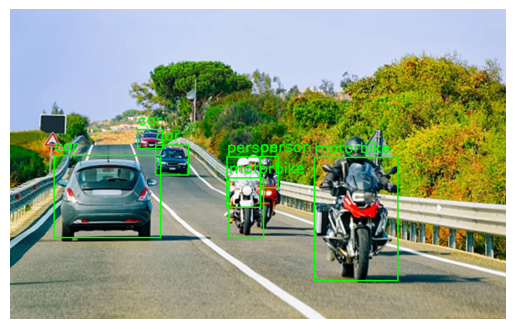

In [3]:
import matplotlib.pyplot as plt

output_path = "output_image.jpg"
cv2.imwrite(output_path, img)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  
plt.show()

- cv2.imwrite(output_path, img)